In [3]:
import xarray as xr
from dask.distributed import Client
import time
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import sys
import numpy as np
import scipy 
import seapy
sys.setrecursionlimit(100000)

In [12]:

#define your observation, forward simulation and da simulation root path
myobsroot = '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/'
# mynlroot = '/Volumes/WD_3/outputs_SCORRECTION/'
mynlroot = '/Volumes/TO_1/roms4dvar_ecs/bio_outputs/'
mypriorroot = '/Volumes/WD_3/roms4dvar_ecs/i4dvar_outputs/'
mypostroot = '/Volumes/LC_1/romsbio_ecs/'
#define your workspace 
# nl_workspace = 'outputs_201205/'
nl_workspace = 'outputs_org/'
prior_workspace = 'workspace_sstbgqc/'
post_workspace = 'workspace_withcruise/'
obs_workspace = ''
#define your filenames
obs_file='sst_withcruiseptpkodc_2012_offshore.nc'
# nl_files = "ocean_ecs_his_001*.nc"
nl_files = "ocean_ecs_avg_00*.nc"
#since this is a vertical profile validation, full fwd file is needed
prior_files = "STORAGE/posterior/ocean_ecs_fwd_1546*.nc"
posterior_files = "STORAGE/fwd/ocean_ecs_fwd_*.nc"

#
grd_file = '/Volumes/TO_1/outputs_SCORRECTION/ocean_ecs_fwd_15461_outer1.nc'


In [15]:
# loading forward sst
start = time.time()
fwd_ds = xr.open_mfdataset(mynlroot+nl_workspace+nl_files,
                                      engine='netcdf4',coords='minimal',
                                      parallel=True,
                                      # chunks={'eta_rho':y_chunk,'xi_rho':x_chunk,
                                      #      's_rho':z_chunk, # only 3d needed
                                      #      'eta_u':y_chunk,'xi_u':x_chunk,\
                                      #      'eta_v':y_chunk,'xi_v':x_chunk,\
                                      #      'eta_psi':y_chunk,'xi_psi':x_chunk,},
                                       )#.chunk(dict(ocean_time=-1))
end = time.time()
print('loading costing %f min'%((end-start)/60))


loading costing 0.721661 min


In [16]:
fwd_time = fwd_ds.ocean_time.data.astype(float)/3600/24*1e-9

In [11]:
mypostroot+post_workspace+posterior_files,

('/Volumes/LC_1/romsbio_ecs/i4dvar_outputs/workspace_withcruise/STORAGE/fwd/ocean_ecs_fwd_*.nc',)

In [13]:
# loading poseterior sst
start = time.time()
post_ds = xr.open_mfdataset(mypostroot+post_workspace+posterior_files,
                                 engine='netcdf4',coords='minimal',
                                 parallel=True,
                                 # chunks={'eta_rho':y_chunk,'xi_rho':x_chunk,
                                 #         # 's_rho':z_chunk, # only 3d needed
                                 #           'eta_u':y_chunk,'xi_u':x_chunk,\
                                 #           'eta_v':y_chunk,'xi_v':x_chunk,\
                                 #           'eta_psi':y_chunk,'xi_psi':x_chunk,},
                                )#.chunk(dict(ocean_time=-1))
post_ds=post_ds.drop_duplicates(dim='ocean_time',keep='last')
end = time.time()
print('loading costing %f min'%((end-start)/60))

loading costing 0.514196 min


In [14]:
post_time = post_ds.ocean_time.data.astype(float)/3600/24*1e-9

In [4]:
np.arange(15765, 15765.5,3)

array([15765.])

In [178]:
# fields= set(['u','v','ubar','vbar','zeta','temp','salt'])
grid = seapy.model.asgrid('/Volumes/TO_1/roms4dvar_ecs/bio_outputs/inputs/grd/ECSLDHY_grd_10River.nc')
ncroms = seapy.netcdf('/Volumes/TO_1/roms4dvar_ecs/bio_outputs/outputs_org/ocean_ecs_avg_0001.nc')
src_ref, romstime = seapy.roms.get_reftime(ncroms)

# for itime in np.arange(15765.5, 15860.5,3):
for itime in np.arange(15765, 15765.5,3):
    print(itime)
    da_tindex = np.argmin(np.abs((post_time-itime)))
    fwd_tindex = np.argmin(np.abs((fwd_time-itime)))

    # ivar = 'salt'
    fwdds_thistime = fwd_ds.isel(ocean_time=fwd_tindex)
    print(fwdds_thistime.ocean_time.data)
    dads_thistime = post_ds.isel(ocean_time=da_tindex)
    print(dads_thistime.ocean_time.data)
    for ivar in ['u','v','ubar','vbar','zeta','temp','salt']:
        null_inda = dads_thistime[ivar].notnull()
        davar_filled = dads_thistime[ivar].where(null_inda,fwdds_thistime[ivar])
        dads_thistime[ivar] = davar_filled
    
    ncini = seapy.roms.ncgen.create_ini('/Volumes/LC_1/romsbio_ecs/workspace_withcruise/daall_rst_%s.nc'%(str(int(itime))),
                                         eta_rho=grid.eta_rho,
                                         xi_rho=grid.xi_rho,
                                         s_rho=grid.n,
                                         reftime=src_ref,
                                         clobber=False,
                                         cdl=None,
                                         title='generated from 4dvar')
    
    grid.to_netcdf(ncini)
    time = dt.datetime(1970,1,1)+dt.timedelta(days=itime)
    ncini.variables["ocean_time"][:] = seapy.roms.date2num(
        time, ncini, "ocean_time")
    for var in seapy.roms.fields:
        if var in ncini.variables and var in ncroms.variables:
            ncini.variables[var] = dads_thistime[var].data.compute()
    ncini.close()
ncroms.close()
    

<class 'netCDF4._netCDF4.Variable'>
float64 temp(s_rho, eta_rho, xi_rho)
    _FillValue: nan
    standard_name: sea_water_potential_temperature
    long_name: potential temperature
    units: Celsius
    time: ocean_time
    cell_methods: ocean_time: point
    grid: grid
    location: face
    field: temperature
    coordinates: lat_rho lon_rho ocean_time
unlimited dimensions: 
current shape = (20, 362, 242)
filling on

In [17]:
fields= set(['u','v','ubar','vbar','zeta','temp','salt'])
for itime in np.arange(15767.5, 15860.5,3):
    print(itime)
    da_tindex = np.argmin(np.abs((post_time-itime)))
    fwd_tindex = np.argmin(np.abs((fwd_time-itime)))

    # ivar = 'salt'
    fwdds_thistime = fwd_ds.isel(ocean_time=fwd_tindex)
    print(fwdds_thistime.ocean_time.data)
    dads_thistime = post_ds.isel(ocean_time=da_tindex)
    print(dads_thistime.ocean_time.data)
    for ivar in ['u','v','ubar','vbar','zeta','temp','salt']:
        null_inda = dads_thistime[ivar].notnull()
        davar_filled = dads_thistime[ivar].where(null_inda,fwdds_thistime[ivar])
        dads_thistime[ivar] = davar_filled
        
    vars_name = set([i for i in dads_thistime.data_vars])
    exclude_vars = vars_name.difference(fields)
    dads_thistime = dads_thistime.expand_dims('ocean_time')
    dads_thistime = dads_thistime.drop_vars(exclude_vars)
    dads_thistime.to_netcdf('/Volumes/LC_1/romsbio_ecs/workspace_withcruise/STORAGE/fwd/da_rst_raw/darst_withcruise_%s_raw.nc'%(str(int(itime-3))))

15767.5
2013-03-03T10:00:00.000000000
2013-03-03T12:00:00.000000000
15770.5
2013-03-06T10:00:00.000000000
2013-03-06T12:00:00.000000000
15773.5
2013-03-09T10:00:00.000000000
2013-03-09T12:00:00.000000000
15776.5
2013-03-12T10:00:00.000000000
2013-03-12T12:00:00.000000000
15779.5
2013-03-15T10:00:00.000000000
2013-03-15T12:00:00.000000000
15782.5
2013-03-18T10:00:00.000000000
2013-03-18T12:00:00.000000000
15785.5
2013-03-21T10:00:00.000000000
2013-03-21T12:00:00.000000000
15788.5
2013-03-24T10:00:00.000000000
2013-03-24T12:00:00.000000000
15791.5
2013-03-27T10:00:00.000000000
2013-03-27T12:00:00.000000000
15794.5
2013-03-30T10:00:00.000000000
2013-03-30T12:00:00.000000000
15797.5
2013-04-02T10:00:00.000000000
2013-04-02T12:00:00.000000000
15800.5
2013-04-05T10:00:00.000000000
2013-04-05T12:00:00.000000000
15803.5
2013-04-08T10:00:00.000000000
2013-04-08T12:00:00.000000000
15806.5
2013-04-11T10:00:00.000000000
2013-04-11T12:00:00.000000000
15809.5
2013-04-14T10:00:00.000000000
2013-04-14

In [192]:
davar_filled.isnull()

<xarray.DataArray 'salt' (s_rho: 20, eta_rho: 362, xi_rho: 242)>
dask.array<isnan, shape=(20, 362, 242), dtype=bool, chunksize=(20, 362, 242), chunktype=numpy.ndarray>
Coordinates:
  * s_rho    (s_rho) float64 -0.975 -0.925 -0.875 ... -0.125 -0.075 -0.025
    lon_rho  (eta_rho, xi_rho) float64 117.7 117.8 117.8 ... 129.6 129.6 129.7
    lat_rho  (eta_rho, xi_rho) float64 25.02 25.0 24.98 ... 39.46 39.45 39.44
Dimensions without coordinates: eta_rho, xi_rho

In [189]:
fwdds_thistime['NO3'].isel(s_rho=-1).compute()

<xarray.DataArray 'NO3' (eta_rho: 362, xi_rho: 242)>
array([[       nan,        nan,        nan, ..., 0.06754067, 0.06783714,
        0.0714966 ],
       [       nan,        nan,        nan, ..., 0.07362353, 0.07495047,
        0.07515606],
       [       nan,        nan,        nan, ..., 0.07807915, 0.07818845,
        0.07759383],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
    s_rho       float64 -0.025
    lon_rho     (eta_rho, xi_rho) float64 117.7 117.8 117.8 ... 129.6 129.7
    lat_rho     (eta_rho, xi_rho) float64 25.02 25.0 24.98 ... 39.46 39.45 39.44
    ocean_time  datetime64[ns] 2012-05-07T10:00:00
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  time-averaged nitrate concentration
    units:      millimole_N03 meter-3
    time:       ocean_time
    field:      NO3, scalar, series

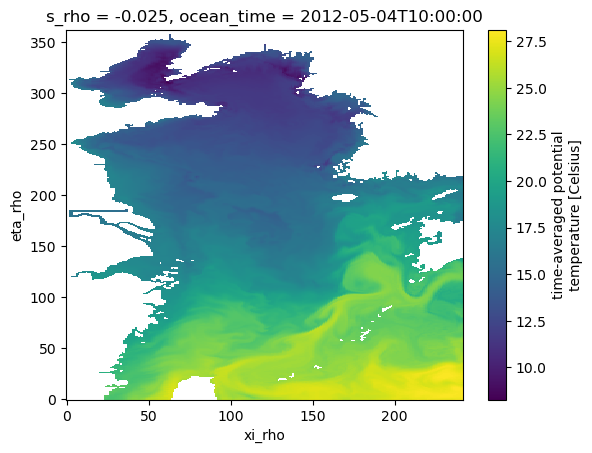

In [85]:
fwdds_thistime['temp'].isel(s_rho=-1).plot()

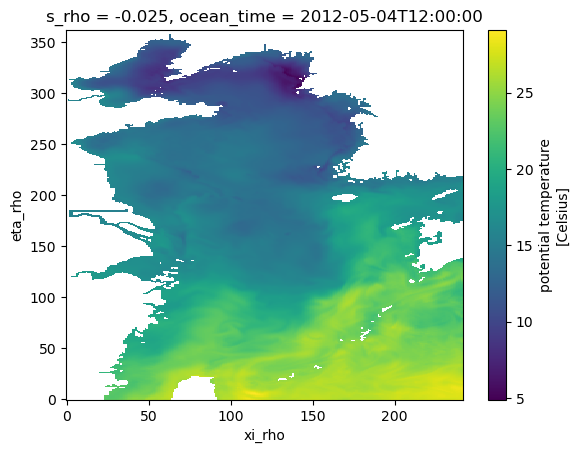

In [94]:
dads_thistime['temp'].isel(s_rho=-1).plot()

In [39]:
null_org = dads_thistime.notnull()


In [40]:
dads_filled = davar_thistime.where(null_org,fwdds_thistime)

ValueError: cannot reindex or align along dimension 'tracer' because of conflicting dimension sizes: {17, 2}

In [36]:
dads_filled['temp'].isel(s_rho=-1).plot(vmin=0,vmax=35)

KeyError: 'temp'

In [37]:
dads_filled

<xarray.DataArray 'salt' (eta_rho: 362, xi_rho: 242, s_rho: 20)>
dask.array<where, shape=(362, 242, 20), dtype=float64, chunksize=(362, 242, 20), chunktype=numpy.ndarray>
Coordinates:
  * s_rho    (s_rho) float64 -0.975 -0.925 -0.875 ... -0.125 -0.075 -0.025
    lon_rho  (eta_rho, xi_rho) float64 117.7 117.8 117.8 ... 129.6 129.6 129.7
    lat_rho  (eta_rho, xi_rho) float64 25.02 25.0 24.98 ... 39.46 39.45 39.44
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    standard_name:  sea_water_practical_salinity
    long_name:      salinity
    time:           ocean_time
    cell_methods:   ocean_time: point
    grid:           grid
    location:       face
    field:          salinity